# Récupération des données

Import des bibliothèques

In [781]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import jarque_bera

Choix du fichier

In [782]:
csv_path = 'GSW_2024.csv'

Nettoyage du fichier et récupération des paramètres NSS que l'on récupère afin de pouvoir modéliser notre courbe des taux à des horizons supérieur à 30 mois

In [783]:
# Lecture du fichier
gsw_data = pd.read_csv(csv_path)

# Mise en forme de la Date comme index
gsw_data['Date'] = pd.to_datetime(gsw_data['Date'])
gsw_data.set_index('Date', inplace=True)

# Sélectionner les données pour avoir seulement les observations de fin de mois
gsw_data = gsw_data.resample('BM').last()

# Filtrer pour commencer à partir de janvier 1987
gsw_data = gsw_data.loc['1987-01-01':]

# Sélectionner les colonnes pour le DataFrame des paramètres NSS
nss_param = gsw_data[['BETA0', 'BETA1', 'BETA2', 'BETA3', 'TAU1', 'TAU2']]

Récupération des rendements dans le fichier

In [784]:
# Création d'une liste des noms de colonnes pour les rendements
yield_column_names = [f'SVENY{str(i).zfill(2)}' for i in range(1, 31)]

# Séléction des colonnes
ZC_yields = gsw_data[yield_column_names]
ZC_yields = ZC_yields/100

**T = 445** : Nombre de dates avec le fichier GSW_2024

**nss_param : (Tx6)** : Dataframe des 6 coefficients NSS sur l'ensemble des dates

In [785]:
nss_param.shape

(445, 6)

In [786]:
nss_param

,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
Date,,,,,,
1987-01-30,8.656263,-2.993882,-620.335484,618.050323,2.077502,2.074807
1987-02-27,8.524844,-2.910494,-620.216079,618.173381,1.934313,1.930422
1987-03-31,8.723477,-2.873167,-620.177288,618.212374,1.879448,1.876236
1987-04-30,8.967513,-3.641063,-619.179602,619.215064,1.004811,1.000865
1987-05-29,9.168855,-3.319059,-619.058563,619.337250,1.260950,1.257066
...,...,...,...,...,...,...
2023-09-29,3.288471,1.679433,3.832298,4.910106,0.582004,15.371016
2023-10-31,2.522215,3.338613,0.000120,8.070969,1.666400,13.158369
2023-11-30,1.489531,4.287763,-0.000197,9.663708,1.733446,13.645988


**ZC_yields : (Tx30)** : Dataframe des rendements de zéros-coupon récupéré sur le fichier GSW

In [787]:
ZC_yields.shape

(445, 30)

In [788]:
ZC_yields.head()

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10,...,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
Date,,,,,,,,,,,,,,,,,,,,,
1987-01-30,0.059760,0.062254,0.064405,0.066337,0.068092,0.069687,0.071127,0.072419,0.073571,0.074596,...,0.080552,0.080823,0.081072,0.081300,0.081510,0.081704,0.081884,0.082051,0.082207,0.082352
1987-02-27,0.060294,0.062886,0.064822,0.066475,0.067981,0.069378,0.070668,0.071850,0.072920,0.073881,...,0.079544,0.079802,0.080038,0.080255,0.080454,0.080638,0.080809,0.080968,0.081115,0.081253
1987-03-31,0.062574,0.065257,0.067329,0.069106,0.070702,0.072153,0.073466,0.074647,0.075699,0.076632,...,0.081961,0.082200,0.082419,0.082619,0.082804,0.082974,0.083132,0.083278,0.083415,0.083542
1987-04-30,0.069239,0.073362,0.075338,0.077036,0.078620,0.080018,0.081197,0.082169,0.082966,0.083621,...,0.086786,0.086918,0.087037,0.087147,0.087248,0.087342,0.087428,0.087508,0.087583,0.087653
1987-05-29,0.071744,0.076402,0.078522,0.079955,0.081184,0.082294,0.083282,0.084143,0.084882,0.085512,...,0.088718,0.088853,0.088976,0.089089,0.089193,0.089289,0.089378,0.089460,0.089537,0.089609


___

# Création des rendements de ZC

Création d'une fonction qui calcule les yields de date et de maturité différentes grâce aux paramètres NSS (Nelson-Siegel-Svensson)

In [789]:
def nss_yield(beta0, beta1, beta2, beta3, tau1, tau2, m):
    return beta0 + beta1 * ((1 - np.exp(-m / tau1)) / (m / tau1)) + \
           beta2 * (((1 - np.exp(-m / tau1)) / (m / tau1)) - np.exp(-m / tau1)) + \
           beta3 * (((1 - np.exp(-m / tau2)) / (m / tau2)) - np.exp(-m / tau2))

Appel de la fonction NSS yield

In [790]:
# Préparation des maturités de 1 à 120 mois en année
maturities = np.arange(1, 121) / 12

# Calcul des rendements pour chaque date et chaque maturité
yield_data = pd.DataFrame(index=nss_param.index)

#Récupération des dates
plot_dates = pd.to_datetime(yield_data.index)

for maturity in maturities:
    yield_data[f'Yield_{int(maturity * 12)}m'] = nss_yield(
        nss_param['BETA0'],
        nss_param['BETA1'],
        nss_param['BETA2'],
        nss_param['BETA3'],
        nss_param['TAU1'],
        nss_param['TAU2'],
        maturity
    )

C:\Users\bossd\AppData\Local\Temp\ipykernel_2692\2731855363.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  yield_data[f'Yield_{int(maturity * 12)}m'] = nss_yield(
C:\Users\bossd\AppData\Local\Temp\ipykernel_2692\2731855363.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  yield_data[f'Yield_{int(maturity * 12)}m'] = nss_yield(
C:\Users\bossd\AppData\Local\Temp\ipykernel_2692\2731855363.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

**N=120** : Nombre de maturitité différentes, ici 120 mois donc 10 ans

**yield_data : (TxN)** : Dataframe des rendements des zéros-coupons calculé grâce aux paramètres NSS

In [791]:
yield_data=yield_data/100
yield_data.shape

(445, 120)

Attribution du nombres de dates et de maturité

In [792]:
T = yield_data.shape[0]
N = yield_data.shape[1]

In [793]:
yield_data.head()

,Yield_1m,Yield_2m,Yield_3m,Yield_4m,Yield_5m,Yield_6m,Yield_7m,Yield_8m,Yield_9m,Yield_10m,...,Yield_111m,Yield_112m,Yield_113m,Yield_114m,Yield_115m,Yield_116m,Yield_117m,Yield_118m,Yield_119m,Yield_120m
Date,,,,,,,,,,,,,,,,,,,,,
1987-01-30,0.056923,0.057213,0.057496,0.057772,0.058040,0.058303,0.058559,0.058809,0.059054,0.059294,...,0.073839,0.073927,0.074013,0.074099,0.074184,0.074268,0.074351,0.074433,0.074515,0.074596
1987-02-27,0.056587,0.057009,0.057410,0.057792,0.058156,0.058504,0.058835,0.059152,0.059456,0.059747,...,0.073170,0.073252,0.073333,0.073414,0.073493,0.073572,0.073650,0.073728,0.073805,0.073881
1987-03-31,0.058929,0.059335,0.059723,0.060094,0.060450,0.060790,0.061117,0.061431,0.061733,0.062023,...,0.075943,0.076023,0.076102,0.076180,0.076257,0.076334,0.076409,0.076484,0.076559,0.076632
1987-04-30,0.055653,0.057766,0.059636,0.061289,0.062752,0.064046,0.065191,0.066205,0.067104,0.067901,...,0.083142,0.083199,0.083254,0.083309,0.083363,0.083417,0.083469,0.083521,0.083571,0.083621
1987-05-29,0.060237,0.061824,0.063270,0.064589,0.065793,0.066890,0.067892,0.068807,0.069643,0.070406,...,0.085049,0.085104,0.085157,0.085210,0.085262,0.085313,0.085364,0.085414,0.085463,0.085512


On normalise les rendements puis on calcule la matrice variance-covariance

In [794]:
# Standardise les rendements
sc_yield_data = StandardScaler(with_std=True).fit_transform(yield_data)[:, 0:120]

# Calcul de la matrice variance-covariance des données standardisées
cov_sc_yield_data = np.cov(sc_yield_data.T)

___

# Comparaison des rendements entre ceux du fichier et ceux calculés

Calcul des erreurs de rendements entre les données GSW et ceux calculé grâce à NSS

In [795]:
# Récupération des dates en commun entre celles des paramètres et des rendements
common_dates = ZC_yields.index.intersection(yield_data.index)
ZC_yields_aligned = ZC_yields.loc[common_dates]
yield_data_aligned = yield_data.loc[common_dates]

# Renommer les colonnes de yield_data pour qu'elles correspondent à celles de ZC_yields
new_column_names = {f'Yield_{int(m * 12)}m': f'SVENY{str(int(m * 12)).zfill(2)}' for m in maturities}
yield_data_aligned.rename(columns=new_column_names, inplace=True)

# Calcul de l'erreur de modélisation
modeling_error = ZC_yields_aligned - yield_data_aligned

# Calcul de la moyenne, de la variance et d'autres statistiques pour l'erreur de modélisation dans un dictionnaire
error_stats = pd.DataFrame({
    'Mean Error': modeling_error.mean(),
    'Variance': modeling_error.var(),
    'Min Error': modeling_error.min(),
    'Max Error': modeling_error.max(),
    'Mean Absolute Error': modeling_error.abs().mean()
})

# Pour supprimer toutes les lignes ayant des NaN dans le DataFrame `error_stats`
error_stats_cleaned = error_stats.dropna()

In [796]:
modeling_error.head()

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10,...,SVENY90,SVENY91,SVENY92,SVENY93,SVENY94,SVENY95,SVENY96,SVENY97,SVENY98,SVENY99
Date,,,,,,,,,,,,,,,,,,,,,
1987-01-30,0.002837,0.005041,0.006909,0.008565,0.010052,0.011384,0.012568,0.013610,0.014517,0.015302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-02-27,0.003707,0.005877,0.007412,0.008683,0.009825,0.010874,0.011833,0.012698,0.013464,0.014134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-03-31,0.003645,0.005922,0.007606,0.009012,0.010252,0.011363,0.012349,0.013216,0.013966,0.014609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-04-30,0.013586,0.015596,0.015702,0.015747,0.015868,0.015972,0.016006,0.015964,0.015862,0.015720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-05-29,0.011507,0.014578,0.015252,0.015366,0.015391,0.015404,0.015390,0.015336,0.015239,0.015106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**error_stats_cleaned : (Tx30)** : Dataframe des différences entre les rendements calculés grâce aux paramètres NSS et ceux obtenus avec la base GSW

In [797]:
error_stats_cleaned

,Mean Error,Variance,Min Error,Max Error,Mean Absolute Error
SVENY01,0.002202,0.000023,-0.011540,0.032812,0.003768
SVENY02,0.004056,0.000038,-0.015009,0.025929,0.005664
SVENY03,0.005816,0.000053,-0.017622,0.024707,0.007501
SVENY04,0.007462,0.000070,-0.018690,0.028588,0.009166
SVENY05,0.008971,0.000087,-0.018844,0.031481,0.010606
SVENY06,0.010331,0.000103,-0.018458,0.033399,0.011877
SVENY07,0.011538,0.000118,-0.017755,0.034578,0.012973
SVENY08,0.012595,0.000131,-0.016873,0.035206,0.013916
SVENY09,0.013511,0.000143,-0.015900,0.037259,0.014721
SVENY10,0.014293,0.000152,-0.015920,0.039012,0.015404


__________________________________________________________________

# Création des dataframes de prix, de rendement sans risque et de l'excess return

La relation entre le prix \( P \) d'une obligation zéro coupon et son rendement \( y \) pour une maturité donnée \( T \) (exprimée en années) est généralement donnée par la formule suivante :

$$ P = \exp(-y \times T) $$

où \( y \) est le rendement à zéro coupon exprimé en termes annuels et \( T \) est la maturité de l'obligation.


In [798]:
# Calcul des prix des obligations zéro coupon à partir des rendements
ZC_prices = np.exp(-yield_data * maturities[np.newaxis, :])
log_ZC_prices = np.log(ZC_prices)
ZC_prices_df = pd.DataFrame(ZC_prices, index=yield_data.index)

# Passage au logarithme
log_ZC_prices_df = np.log(ZC_prices_df)

**ZC_prices_df : (TxN)** : Dataframe des prix des zéros coupons <br> (P) dans le papier

In [799]:
ZC_prices_df.shape

(445, 120)

**log_ZC_prices_df : (TxN)** : Dataframe du logarithme des prix des zéros coupons <br> ln(P) dans le papier

In [800]:
# Vérification de présence de 'Nan' ou valeur infini

if np.isnan(log_ZC_prices_df.to_numpy()).any():
    print("log_ZC_prices_df contient des NaN.")
if np.isinf(log_ZC_prices_df.to_numpy()).any():
    print("log_ZC_prices_df contient des infinis.")

In [801]:
log_ZC_prices_df.tail()

,Yield_1m,Yield_2m,Yield_3m,Yield_4m,Yield_5m,Yield_6m,Yield_7m,Yield_8m,Yield_9m,Yield_10m,...,Yield_111m,Yield_112m,Yield_113m,Yield_114m,Yield_115m,Yield_116m,Yield_117m,Yield_118m,Yield_119m,Yield_120m
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-29,-0.004263,-0.008716,-0.013287,-0.017919,-0.022570,-0.027209,-0.031812,-0.036362,-0.040847,-0.045261,...,-0.428708,-0.432800,-0.436896,-0.440998,-0.445103,-0.449214,-0.453328,-0.457447,-0.461570,-0.465697
2023-10-31,-0.004837,-0.009583,-0.014245,-0.018829,-0.023339,-0.027780,-0.032158,-0.036477,-0.040741,-0.044954,...,-0.455290,-0.459747,-0.464209,-0.468676,-0.473149,-0.477627,-0.482110,-0.486597,-0.491090,-0.495587
2023-11-30,-0.004754,-0.009394,-0.013925,-0.018354,-0.022689,-0.026935,-0.031098,-0.035184,-0.039196,-0.043142,...,-0.407106,-0.411140,-0.415181,-0.419228,-0.423282,-0.427343,-0.431410,-0.435484,-0.439563,-0.443649
2023-12-29,-0.004696,-0.009204,-0.013541,-0.017722,-0.021763,-0.025676,-0.029474,-0.033168,-0.036768,-0.040283,...,-0.359486,-0.362951,-0.366420,-0.369895,-0.373375,-0.376859,-0.380349,-0.383843,-0.387341,-0.390844
2024-01-31,-0.004773,-0.009288,-0.013577,-0.017668,-0.021586,-0.025354,-0.028990,-0.032512,-0.035935,-0.039273,...,-0.365539,-0.369143,-0.372752,-0.376366,-0.379987,-0.383612,-0.387243,-0.390880,-0.394521,-0.398168


Récupération du rendement sans risque

In [802]:
rfr = -log_ZC_prices_df.iloc[:,0]
rfr_df = pd.DataFrame(rfr)
rfr_df

,Yield_1m
Date,
1987-01-30,0.004744
1987-02-27,0.004716
1987-03-31,0.004911
1987-04-30,0.004638
1987-05-29,0.005020
...,...
2023-09-29,0.004263
2023-10-31,0.004837
2023-11-30,0.004754


**rfr_df : (Tx1)** : Dataframe du rendement sans risque (ici une obligation 1 mois) <br> r dans le papier

log_ZC_prices_1 : Sans la dernière colonne ni la première ligne <br> maturité : 1 à N-1 et t : 2 à T

log_ZC_prices_2 : Sans la première colonne ni la dernière ligne <br> maturité : 2 à N et t : 1 à T-1

In [803]:
# Séparation de log_ZC_prices pour calculer l'excess return

log_ZC_prices_1 = log_ZC_prices_df.iloc[1:, :-1].to_numpy()
log_ZC_prices_2 = log_ZC_prices_df.iloc[:-1, 1:].to_numpy()

In [804]:
# Dupliquer la colonne (N-1) fois où N est le nombre de colonnes dans sliced_df_1
rfr_matrix = np.tile(rfr.iloc[:-1].to_numpy().reshape(-1, 1), (1, N-1))
rfr_matrix.shape

(444, 119)

In [805]:
# Calcul des rendements excédentaires
rx = log_ZC_prices_1 - log_ZC_prices_2 - rfr_matrix

# Créer un nouveau DataFrame pour les rendements excédentaires avec les bons noms de colonnes
rx_df = pd.DataFrame(rx, columns=[f'Excess_Return_{n}m' for n in range(2, log_ZC_prices_1.shape[1]+2)])
rx_df.index = log_ZC_prices_df.iloc[1:, :-1].index

rx = rx.T
rx_df = rx_df.T

In [894]:
rx_df.T.describe()

,Excess_Return_2m,Excess_Return_3m,Excess_Return_4m,Excess_Return_5m,Excess_Return_6m,Excess_Return_7m,Excess_Return_8m,Excess_Return_9m,Excess_Return_10m,Excess_Return_11m,...,Excess_Return_111m,Excess_Return_112m,Excess_Return_113m,Excess_Return_114m,Excess_Return_115m,Excess_Return_116m,Excess_Return_117m,Excess_Return_118m,Excess_Return_119m,Excess_Return_120m
count,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,...,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000
mean,0.000043,0.000079,0.000113,0.000147,0.000180,0.000214,0.000247,0.000281,0.000315,0.000348,...,0.002768,0.002781,0.002793,0.002806,0.002819,0.002831,0.002843,0.002855,0.002867,0.002879
std,0.000233,0.000391,0.000539,0.000700,0.000879,0.001075,0.001284,0.001503,0.001730,0.001963,...,0.025059,0.025264,0.025468,0.025672,0.025876,0.026079,0.026282,0.026484,0.026687,0.026889
min,-0.000683,-0.001118,-0.001724,-0.002354,-0.003006,-0.003675,-0.004358,-0.005051,-0.005754,-0.006462,...,-0.089839,-0.090771,-0.091701,-0.092628,-0.093553,-0.094475,-0.095394,-0.096311,-0.097225,-0.098137
25%,-0.000072,-0.000125,-0.000178,-0.000225,-0.000276,-0.000330,-0.000403,-0.000478,-0.000553,-0.000633,...,-0.011921,-0.012166,-0.012311,-0.012410,-0.012464,-0.012496,-0.012527,-0.012557,-0.012587,-0.012659
50%,0.000003,0.000008,0.000006,0.000012,0.000014,0.000024,0.000036,0.000041,0.000045,0.000074,...,0.002572,0.002674,0.002798,0.002800,0.002815,0.002700,0.002780,0.002778,0.002852,0.002901
75%,0.000105,0.000211,0.000292,0.000389,0.000518,0.000637,0.000754,0.000911,0.001040,0.001179,...,0.017981,0.018072,0.017993,0.017897,0.017989,0.018186,0.018375,0.018552,0.018729,0.018897
max,0.001545,0.002157,0.002901,0.003802,0.004672,0.005512,0.006325,0.007111,0.007873,0.008610,...,0.113042,0.114205,0.115361,0.116511,0.117653,0.118788,0.119916,0.121037,0.122150,0.123255


**rx_df : (N-1xT-1)** : Dataframe des "excess return" <br> D'après le papier dimension (NxT) mais impossible

In [806]:
rx_df.shape

(119, 444)

In [807]:
# Vérification de présence de 'Nan' ou valeurs infini dans rx

if np.isnan(rx_df.to_numpy()).any():
    print("rx contient des NaN.")
if np.isinf(rx_df.to_numpy()).any():
    print("rx contient des infinis.")

In [808]:
rx_df.T

,Excess_Return_2m,Excess_Return_3m,Excess_Return_4m,Excess_Return_5m,Excess_Return_6m,Excess_Return_7m,Excess_Return_8m,Excess_Return_9m,Excess_Return_10m,Excess_Return_11m,...,Excess_Return_111m,Excess_Return_112m,Excess_Return_113m,Excess_Return_114m,Excess_Return_115m,Excess_Return_116m,Excess_Return_117m,Excess_Return_118m,Excess_Return_119m,Excess_Return_120m
Date,,,,,,,,,,,,,,,,,,,,,
1987-02-27,0.000076,0.000129,0.000161,0.000176,0.000176,0.000164,0.000142,0.000112,0.000076,0.000036,...,0.008299,0.008414,0.008527,0.008641,0.008754,0.008867,0.008979,0.009091,0.009203,0.009315
1987-03-31,-0.000125,-0.000252,-0.000382,-0.000515,-0.000651,-0.000790,-0.000932,-0.001078,-0.001226,-0.001378,...,-0.023299,-0.023504,-0.023708,-0.023911,-0.024114,-0.024315,-0.024516,-0.024717,-0.024916,-0.025115
1987-04-30,0.000341,0.000392,0.000212,-0.000153,-0.000662,-0.001282,-0.001985,-0.002748,-0.003553,-0.004384,...,-0.064041,-0.064426,-0.064805,-0.065180,-0.065551,-0.065917,-0.066279,-0.066636,-0.066990,-0.067339
1987-05-29,-0.000030,-0.000033,-0.000025,-0.000021,-0.000028,-0.000055,-0.000105,-0.000181,-0.000285,-0.000418,...,-0.014691,-0.014824,-0.014959,-0.015095,-0.015232,-0.015370,-0.015509,-0.015650,-0.015792,-0.015934
1987-06-30,0.000095,0.000284,0.000548,0.000868,0.001232,0.001626,0.002039,0.002463,0.002891,0.003316,...,0.007470,0.007492,0.007514,0.007536,0.007558,0.007581,0.007603,0.007625,0.007647,0.007669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,0.000505,0.000723,0.000730,0.000587,0.000340,0.000024,-0.000333,-0.000710,-0.001093,-0.001472,...,-0.051351,-0.051900,-0.052446,-0.052988,-0.053527,-0.054062,-0.054593,-0.055121,-0.055646,-0.056167
2023-10-31,-0.000384,-0.000560,-0.000590,-0.000522,-0.000393,-0.000232,-0.000060,0.000107,0.000257,0.000383,...,-0.026395,-0.026754,-0.027114,-0.027474,-0.027836,-0.028199,-0.028562,-0.028926,-0.029290,-0.029656
2023-11-30,-0.000008,0.000015,0.000067,0.000147,0.000254,0.000386,0.000542,0.000720,0.000921,0.001141,...,0.047373,0.047804,0.048232,0.048659,0.049084,0.049508,0.049930,0.050350,0.050769,0.051187


___

# Décomposition des facteurs

1ère méthode

In [809]:
#Choix du nombre de facteur
K=5

In [810]:
[valeurs_propres_2, vecteurs_propres_2] = np.linalg.eig(cov_sc_yield_data)

In [811]:
pca_factors_2 = StandardScaler().fit_transform(sc_yield_data @ np.real(vecteurs_propres_2))
pca_factors_2_df = pd.DataFrame(pca_factors_2)
pca_factors_2_df

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,1.135857,0.310703,-0.664952,-0.048086,-0.262195,0.337557,-0.405946,-0.215706,-0.525973,-0.950704,...,-0.011325,-0.068922,-0.170368,-0.055743,0.080572,0.080572,0.093966,0.064507,-0.001378,-0.081515
1,1.131472,0.210274,-0.419672,0.154725,-0.517809,0.292362,-0.241471,0.056517,-0.386580,-1.151777,...,-0.192765,0.399341,0.307768,0.370155,-0.373609,-0.373609,-0.362400,0.051998,-0.113276,0.314393
2,1.242320,0.278429,-0.491751,0.019976,-0.343719,0.213423,-0.221177,0.008748,-0.475455,-1.184166,...,-0.193032,0.228238,0.201171,0.283143,-0.262282,-0.262282,-0.178746,-0.092297,-0.070278,0.210471
3,1.548904,0.537347,0.791147,1.954090,0.706925,-2.744254,-0.296677,-3.540622,-3.418809,0.012009,...,0.088817,3.056614,0.874888,1.263667,-1.569661,-1.569661,-3.112432,3.375894,-0.333776,1.608925
4,1.654312,0.451450,0.839944,1.267896,-0.521474,-1.493623,0.731408,-0.552983,-2.208612,-3.386926,...,1.090013,-3.631350,-3.390631,-3.088955,3.254543,3.254543,3.481512,-0.130151,1.297248,-2.800193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,0.287440,-1.705987,-0.702112,1.738186,1.258193,-1.529307,-1.483590,-2.279792,0.141083,2.797221,...,0.011499,-1.345677,0.374895,-0.678203,0.513890,0.513890,0.846129,-1.353342,-0.084610,-0.546359
441,0.365458,-1.508459,-1.441855,-0.348733,-0.171673,-0.041867,0.309669,0.069968,-0.310888,0.095475,...,0.083249,-0.087936,-0.004209,-0.076749,0.062792,0.062792,0.057384,-0.120498,-0.111403,-0.079593
442,0.179905,-1.810150,-1.671987,-0.208403,-0.346329,0.020086,0.329426,-0.012474,-0.384248,0.081921,...,0.063166,0.056945,0.141725,0.028518,-0.062071,-0.062071,-0.096836,-0.081461,-0.152899,0.030588
443,-0.011457,-1.994643,-1.954767,-1.095760,0.395789,0.076676,0.153997,-0.254235,-0.462935,0.369759,...,0.149226,-0.109370,-0.082466,-0.116734,0.120688,0.120688,0.105483,-0.126842,-0.210925,-0.147898


2ème méthode

In [812]:
# Choix du nombre de composante
pca = PCA(n_components=K)

# Récupération des VPs
pca.fit(cov_sc_yield_data)
valeur_propre = pca.explained_variance_
vecteur_propre = pca.components_

# Récupération des facteurs
pca_factors = pca.transform(cov_sc_yield_data)

# Créer un DataFrame avec les facteurs PCA
pca_factors_df = pd.DataFrame(pca_factors, columns=[f'Factor_{i+1}' for i in range(5)])

**valeur_propre : (Kx1)**

In [813]:
valeur_propre.shape

(5,)

**vecteur_propre : (KxN)**

In [814]:
vecteur_propre.shape

(5, 120)

In [815]:
# Pourcentage de variance expliquée par chaque composant
explained_variance_ratio = pca.explained_variance_ratio_

# Pourcentage cumulatif de variance expliquée
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Afficher le pourcentage de variance expliquée par chaque facteur principal
print("Explained variance ratio by component: ", explained_variance_ratio)
print("Cumulative explained variance ratio: ", cumulative_variance_ratio)

Explained variance ratio by component:  [8.43202788e-01 1.56695516e-01 9.55084014e-05 6.13323986e-06
 5.02125134e-08]
Cumulative explained variance ratio:  [0.84320279 0.9998983  0.99999381 0.99999995 1.        ]


In [816]:
X = pca_factors_2[:, 0:K].T
X = pd.DataFrame(X)

#X = pca_factors_df.T
#X

X

,0,1,2,3,4,5,6,7,8,9,...,435,436,437,438,439,440,441,442,443,444
0,1.135857,1.131472,1.242320,1.548904,1.654312,1.604119,1.669402,1.799057,2.065855,1.767062,...,-0.136062,-0.029673,0.077279,0.116101,0.143280,0.287440,0.365458,0.179905,-0.011457,-0.017606
1,0.310703,0.210274,0.278429,0.537347,0.451450,0.563464,0.804035,0.789373,0.877245,0.992017,...,-2.362107,-2.482228,-2.266851,-2.343751,-2.250118,-1.705987,-1.508459,-1.810150,-1.994643,-1.849087
2,-0.664952,-0.419672,-0.491751,0.791147,0.839944,0.262985,0.388847,0.462590,0.785346,1.133105,...,-1.965045,-2.140388,0.696563,-0.812617,-1.195685,-0.702112,-1.441855,-1.671987,-1.954767,-2.320383
3,-0.048086,0.154725,0.019976,1.954090,1.267896,-0.195124,-0.169326,-0.084955,0.466600,0.454457,...,-0.758242,-0.536466,4.357714,0.392150,-0.262475,1.738186,-0.348733,-0.208403,-1.095760,-1.740474
4,-0.262195,-0.517809,-0.343719,0.706925,-0.521474,-0.061940,-0.265219,-0.284405,-0.413059,1.229136,...,0.233176,-0.112379,4.410306,-0.936382,-0.667745,1.258193,-0.171673,-0.346329,0.395789,0.464791


In [817]:
pca_factors_df.T

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
Factor_1,0.809043,0.778311,0.750581,0.724031,0.698044,0.672436,0.647181,0.622309,0.597865,0.573890,...,-0.308625,-0.310307,-0.311937,-0.313515,-0.315043,-0.316523,-0.317956,-0.319342,-0.320684,-0.321982
Factor_2,0.397802,0.336096,0.289976,0.251893,0.218602,0.188565,0.160993,0.135453,0.111683,0.089513,...,0.180164,0.186171,0.192146,0.198089,0.203999,0.209873,0.215712,0.221513,0.227277,0.233001
Factor_3,0.014202,0.011116,0.008143,0.005564,0.003408,0.001632,0.000181,-0.000996,-0.001945,-0.002705,...,-0.003097,-0.003330,-0.003565,-0.003801,-0.004038,-0.004277,-0.004517,-0.004757,-0.004999,-0.005241
Factor_4,0.004597,0.001852,0.000299,-0.000618,-0.001160,-0.001466,-0.001617,-0.001662,-0.001634,-0.001554,...,0.000515,0.000589,0.000665,0.000742,0.000820,0.000900,0.000981,0.001064,0.001147,0.001232
Factor_5,0.000211,0.000108,-0.000019,-0.000110,-0.000160,-0.000176,-0.000168,-0.000145,-0.000112,-0.000076,...,-0.000036,-0.000046,-0.000056,-0.000067,-0.000078,-0.000089,-0.000101,-0.000113,-0.000125,-0.000138


**X : (KxT)** : Matrice des facteurs <br> **Xt : (Kx1)** : Facteurs à une date

___

# Régression des facteurs

Effectuer l'estimation VAR en utilisant numpy pour les opérations matricielles. Nous souhaitons estimer le modèle : Y = mu + Phi * X_lagged + erreurs où Y sont les données originales (sans la première période temporelle), X_lagged sont les données décalées d'une période temporelle


In [818]:
X_lagged = X.iloc[:, :-1]  # Supprime la dernière colonne
Y = X.iloc[:, 1:]  # Supprimer la première période

In [819]:
X.tail

<bound method NDFrame.tail of         0         1         2         3         4         5         6    \
0  1.135857  1.131472  1.242320  1.548904  1.654312  1.604119  1.669402   
1  0.310703  0.210274  0.278429  0.537347  0.451450  0.563464  0.804035   
2 -0.664952 -0.419672 -0.491751  0.791147  0.839944  0.262985  0.388847   
3 -0.048086  0.154725  0.019976  1.954090  1.267896 -0.195124 -0.169326   
4 -0.262195 -0.517809 -0.343719  0.706925 -0.521474 -0.061940 -0.265219   

        7         8         9    ...       435       436       437       438  \
0  1.799057  2.065855  1.767062  ... -0.136062 -0.029673  0.077279  0.116101   
1  0.789373  0.877245  0.992017  ... -2.362107 -2.482228 -2.266851 -2.343751   
2  0.462590  0.785346  1.133105  ... -1.965045 -2.140388  0.696563 -0.812617   
3 -0.084955  0.466600  0.454457  ... -0.758242 -0.536466  4.357714  0.392150   
4 -0.284405 -0.413059  1.229136  ...  0.233176 -0.112379  4.410306 -0.936382   

        439       440       441       

In [820]:
X_lagged.tail

<bound method NDFrame.tail of         0         1         2         3         4         5         6    \
0  1.135857  1.131472  1.242320  1.548904  1.654312  1.604119  1.669402   
1  0.310703  0.210274  0.278429  0.537347  0.451450  0.563464  0.804035   
2 -0.664952 -0.419672 -0.491751  0.791147  0.839944  0.262985  0.388847   
3 -0.048086  0.154725  0.019976  1.954090  1.267896 -0.195124 -0.169326   
4 -0.262195 -0.517809 -0.343719  0.706925 -0.521474 -0.061940 -0.265219   

        7         8         9    ...       434       435       436       437  \
0  1.799057  2.065855  1.767062  ... -0.122440 -0.136062 -0.029673  0.077279   
1  0.789373  0.877245  0.992017  ... -2.174174 -2.362107 -2.482228 -2.266851   
2  0.462590  0.785346  1.133105  ... -1.271390 -1.965045 -2.140388  0.696563   
3 -0.084955  0.466600  0.454457  ... -0.817952 -0.758242 -0.536466  4.357714   
4 -0.284405 -0.413059  1.229136  ...  0.110869  0.233176 -0.112379  4.410306   

        438       439       440       

In [821]:
print("Dimension of X_lagged :", X_lagged.shape)
print("Dimension of Y:", Y.shape)

Dimension of X_lagged : (5, 444)
Dimension of Y: (5, 444)


In [822]:
# Conversion des DataFrames en numpy arrays
X_lagged_np = X_lagged.to_numpy()
Y_np = Y.to_numpy()

# Ajout d'une colonne de 1 pour le terme constant dans X_lagged_np pour la régression
X_with_intercept = np.vstack([np.ones((1, X_lagged_np.shape[1])), X_lagged_np])

# Régression de Y sur X_lagged_np 
# Utilisation de la formule (X'X)^(-1)X'Y pour estimer les coefficients
XtX = np.dot(X_with_intercept, X_with_intercept.T)
XtY = np.dot(X_with_intercept, Y_np.T)
coefficients = np.dot(np.linalg.inv(XtX), XtY)

# La première ligne des coefficients contient les valeurs de mu (terme constant pour chaque facteur)
mu = coefficients[0, :]

# Le reste des coefficients correspond à Phi (matrice des coefficients pour chaque facteur)
Phi = coefficients[1:, :]

# Affichage des résultats
print("Estimation de mu :", mu)
print("Estimation de Phi :")
print(Phi)

Estimation de mu : [-0.00267503 -0.00449624 -0.00281016 -0.00249714  0.00239367]
Estimation de Phi :
[[ 0.99272804 -0.00517062 -0.03593752 -0.01566591  0.00417674]
 [-0.00464581  0.98281499  0.02730451  0.01739206 -0.01097255]
 [ 0.01017192 -0.04140163  0.86646344 -0.06460609 -0.06003004]
 [ 0.00569294 -0.02724282 -0.11092782  0.66369655 -0.21991941]
 [-0.02034414 -0.02558073 -0.09756544 -0.25752964  0.55577892]]


**mu : (Kx1)**

In [823]:
mu.shape

(5,)

**Phi : (KxK)**

In [824]:
Phi.shape

(5, 5)

In [825]:
# Calcul des valeurs prédites
Y_pred = X_with_intercept.T @ coefficients

# Calcul des résidus
v = Y_np - Y_pred.T

# Création d'un DataFrame
v_df = pd.DataFrame(v, index=Y.index, columns=Y.columns)
v_df

,1,2,3,4,5,6,7,8,9,10,...,435,436,437,438,439,440,441,442,443,444
0,0.009697,0.115582,0.317482,0.117053,-0.059761,0.079416,0.139818,0.276216,-0.296069,0.049298,...,-0.002094,0.126149,0.120419,0.089358,0.006793,0.137495,0.097701,-0.174069,-0.184641,0.021350
1,-0.120267,0.055710,0.246015,0.039916,0.188798,0.267032,0.016985,0.124799,0.179685,0.138776,...,-0.293518,-0.252969,0.070957,0.149414,0.011539,0.436965,0.224663,-0.394815,-0.293933,0.015057
2,0.160715,-0.123746,1.225765,0.483980,-0.325093,0.178365,0.121860,0.393266,0.517189,0.063593,...,-0.885574,-0.436692,2.550178,-0.434996,-0.468462,0.309038,-0.458210,-0.420975,-0.504258,-0.652722
3,0.091044,-0.226613,1.837661,0.221556,-1.096090,-0.020957,-0.001087,0.496580,0.108743,0.685557,...,-0.230565,-0.058680,4.591745,-1.276130,-0.771312,1.707053,-1.187029,-0.079856,-1.117857,-1.000575
4,-0.426307,-0.051910,0.868303,-0.440100,0.552791,-0.260829,-0.151442,-0.247153,1.607068,0.395654,...,-0.110387,-0.554430,4.196791,-2.414967,-0.138459,1.472129,-0.553151,-0.434636,0.419063,-0.137735


In [826]:
jarque_bera_results = v_df.T.apply(lambda column: jarque_bera(column))
indexes = ['statistic','p-value']
noms_colonnes = ['factor 1','factor 2','factor 3','factor 4','factor 5']
jarque_bera_results.index = indexes
jarque_bera_results.columns = noms_colonnes
jarque_bera_results

,factor 1,factor 2,factor 3,factor 4,factor 5
statistic,5.963839,5.732311e+01,275.790598,3767.025635,6448.89033
p-value,0.050695,3.568257e-13,0.000000,0.000000,0.00000


In [827]:
# Calcul de la matrice de variance-covariance des résidus
sigma = (v_df @ v_df.T) / T
sigma

,0,1,2,3,4
0,0.011020,0.009157,0.027561,0.007530,0.009549
1,0.009157,0.037119,0.011061,-0.003930,0.013690
2,0.027561,0.011061,0.232624,0.108349,0.078452
3,0.007530,-0.003930,0.108349,0.491472,0.283353
4,0.009549,0.013690,0.078452,0.283353,0.640293


___

# Régression des "Excess return"

In [828]:
# Matrice des facteurs sans la dernière date
X_ = X.iloc[:,:-1]
X_

,0,1,2,3,4,5,6,7,8,9,...,434,435,436,437,438,439,440,441,442,443
0,1.135857,1.131472,1.242320,1.548904,1.654312,1.604119,1.669402,1.799057,2.065855,1.767062,...,-0.122440,-0.136062,-0.029673,0.077279,0.116101,0.143280,0.287440,0.365458,0.179905,-0.011457
1,0.310703,0.210274,0.278429,0.537347,0.451450,0.563464,0.804035,0.789373,0.877245,0.992017,...,-2.174174,-2.362107,-2.482228,-2.266851,-2.343751,-2.250118,-1.705987,-1.508459,-1.810150,-1.994643
2,-0.664952,-0.419672,-0.491751,0.791147,0.839944,0.262985,0.388847,0.462590,0.785346,1.133105,...,-1.271390,-1.965045,-2.140388,0.696563,-0.812617,-1.195685,-0.702112,-1.441855,-1.671987,-1.954767
3,-0.048086,0.154725,0.019976,1.954090,1.267896,-0.195124,-0.169326,-0.084955,0.466600,0.454457,...,-0.817952,-0.758242,-0.536466,4.357714,0.392150,-0.262475,1.738186,-0.348733,-0.208403,-1.095760
4,-0.262195,-0.517809,-0.343719,0.706925,-0.521474,-0.061940,-0.265219,-0.284405,-0.413059,1.229136,...,0.110869,0.233176,-0.112379,4.410306,-0.936382,-0.667745,1.258193,-0.171673,-0.346329,0.395789


Création des matrices unitaires it et in

In [829]:
it = np.ones((T-1,1))
i_n = np.ones((N-1,1))

In [830]:
# Création de la matrice nécessaire pour déterminer a, beta et c
Z = np.hstack([it,v.T,X_.T]).T

**Z : (2K+1)x(T-1)**

In [831]:
Z.shape

(11, 444)

In [832]:
# Calcul de la matrice a beta c
abc_l = np.dot(rx,Z.T)
abc_r = np.linalg.inv(Z @ Z.T)
abc = np.dot(abc_l,abc_r)

abc.shape

(119, 11)

In [833]:
# Isolation des paramètres
a = abc[:, [0]]
beta = abc[:, 1:K+1].T
c = abc[:, K+1:]

In [834]:
print("Dimension of a :", a.shape)
print("Dimension of beta :", beta.shape)
print("Dimension of c:", c.shape)

Dimension of a : (119, 1)
Dimension of beta : (5, 119)
Dimension of c: (119, 5)


In [835]:
# Calcul des résidus
E = rx-np.dot(abc,Z)

In [836]:
E

array([[ 1.75303962e-06,  2.68577354e-07, -3.64048252e-05, ...,
        -1.83735345e-06,  1.17578497e-06,  9.62415988e-06],
       [ 2.36594145e-06,  3.45457345e-06,  1.91121283e-05, ...,
         9.86079359e-07,  1.14183665e-05, -1.02367381e-06],
       [ 1.88015197e-06,  4.89806232e-06,  8.78046732e-05, ...,
         4.69419720e-06,  2.20537534e-05, -1.66006846e-05],
       ...,
       [ 1.07229341e-04, -3.30846108e-05,  1.32230691e-03, ...,
         1.68337482e-04,  3.43903521e-04, -4.03389262e-04],
       [ 1.21657026e-04, -3.92543681e-05,  1.43520286e-03, ...,
         1.89294111e-04,  3.81393384e-04, -4.47142963e-04],
       [ 1.36854527e-04, -4.57510512e-05,  1.55011126e-03, ...,
         2.11162921e-04,  4.20284244e-04, -4.92467605e-04]])

In [837]:
# Variance des résidus de la régression
sigma2 = np.trace(E @ E.T) / (N * T)

In [838]:
sigma2

2.439252894596975e-08

In [839]:
# Initialisation de la matrice B*
B_star = np.zeros((N-1, 5*5))

for i in range(N-1):
    # Produit extérieur 
    beta_outer = np.outer(beta[:, i], beta[:, i])
    # Convertir la matrice en vecteur en empilant ses colonnes
    B_star[i, :] = beta_outer.flatten()

B_star_df = pd.DataFrame(B_star)
B_star_df.shape

(119, 25)

**B_star_df : (N-1)xK²**

In [840]:
# Calcul de l'inverse de beta_hat transposé fois beta_hat
inv_beta_transpose_beta = np.linalg.inv(beta @ beta.T)

# Calcul de vec qui est la version aplatie de Sigma_hat
vec_sigma = sigma.to_numpy().flatten()

B_star_vec_sigma = (B_star @ vec_sigma).reshape(-1, 1)

___

# Estimation des paramètres de marché

In [841]:
# Calcul de lambda_0 et lambda_1
lambda_0 = inv_beta_transpose_beta @ beta @ (a + 0.5 * (B_star_vec_sigma + sigma2 * i_n))
lambda_1 = inv_beta_transpose_beta @ beta @ c

In [842]:
lambda_0

array([[-0.01614258],
       [ 0.00490006],
       [ 0.00577402],
       [ 0.03627026],
       [ 0.00291083]])

In [843]:
lambda_1

array([[-0.00928658, -0.01512009,  0.00493442,  0.00228035, -0.02154334],
       [ 0.02633031, -0.00708928,  0.00098312, -0.00156077, -0.0136278 ],
       [ 0.06041336, -0.02273065, -0.03776178,  0.02341955, -0.03742939],
       [ 0.06173477, -0.04946164, -0.01729101, -0.13722194, -0.08374006],
       [ 0.03122868, -0.05248397, -0.03666021, -0.15823282, -0.30723969]])

In [844]:
DELTA = np.hstack((lambda_0,lambda_1))

In [845]:
# Créez la matrice identité de la même taille que sigma_inv
I = np.eye(sigma.shape[0])

# Effectuez la multiplication de Kronecker entre I et sigma_inv
vega = sigma2 * np.kron(I, np.linalg.inv(sigma))

In [846]:
vega.shape

(25, 25)

___

# Regression du taux sans risque sur les facteurs

In [847]:
rfr.shape

(445,)

In [848]:
# Supposons que X est votre matrice de facteurs de prix et rfr est votre matrice de taux court
# Transposez X et rfr pour avoir les bonnes dimensions
X_tr = X.T  # X est maintenant de dimension (T x K)
#rfr = rfr.reshape(-1, 1)  # Assurez-vous que rfr est une matrice colonne de dimension (T x 1)

# Ajoutez une colonne de 1 à X pour l'intercept
X_with_intercept = np.hstack([np.ones((X_tr.shape[0], 1)), X_tr])

# Calculez (X'X)
XtX = np.dot(X_with_intercept.T, X_with_intercept)

# Calculez l'inverse de (X'X)
XtX_inv = np.linalg.inv(XtX)

# Calculez (X'Y)
XtY = np.dot(X_with_intercept.T, rfr)

# Calculez les coefficients de régression (delta)
delta = np.dot(XtX_inv, XtY)

delta_0 = delta[0]
delta_1 = delta[1:]

# delta contient maintenant l'intercept en première ligne et les coefficients pour les facteurs de prix

# Création des matrices A et B

In [849]:
# Création des matrices A et B
A = np.zeros((1, N))
B = np.zeros((K, N))

In [850]:
# Initialisation
A[0,1] = -delta_0
B[:,1] = -delta_1.T

In [851]:
# Récurrence de B
for i in range(2,N):
    B.T[i,:] = (B.T[i-1,:] @ (Phi-lambda_1)) - delta_1.T

In [852]:
# Transformation en dataframe
B_df = pd.DataFrame(B)
B_df

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.0,-0.001889,-0.003829,-0.005818,-0.007853,-0.009932,-0.012055,-0.014220,-0.016426,-0.018672,...,-0.151870,-0.149504,-0.147050,-0.144509,-0.141883,-0.139173,-0.136381,-0.133508,-0.130557,-0.127528
1,0.0,0.000699,0.001372,0.002014,0.002622,0.003194,0.003727,0.004218,0.004665,0.005067,...,-0.175222,-0.176730,-0.178165,-0.179523,-0.180805,-0.182008,-0.183130,-0.184171,-0.185128,-0.186001
2,0.0,0.000302,0.000654,0.001059,0.001518,0.002030,0.002595,0.003212,0.003878,0.004593,...,0.067306,0.066129,0.064907,0.063641,0.062331,0.060979,0.059585,0.058150,0.056674,0.055160
3,0.0,0.000144,0.000275,0.000399,0.000520,0.000641,0.000762,0.000884,0.001007,0.001130,...,-0.014645,-0.014844,-0.015036,-0.015220,-0.015396,-0.015564,-0.015725,-0.015876,-0.016020,-0.016154
4,0.0,0.000052,0.000023,-0.000075,-0.000236,-0.000452,-0.000718,-0.001031,-0.001385,-0.001779,...,-0.032848,-0.032195,-0.031521,-0.030826,-0.030111,-0.029376,-0.028621,-0.027848,-0.027057,-0.026248


In [853]:
# Changement de forme de mu
mu = mu.reshape(-1, 1)

# Récurrence de A
for i in range(2, N):
    A[0,i] = A[0,i-1] + (B.T[i-1,:] @ (mu-lambda_0)) + 0.5 * (B.T[i-1,:] @ sigma @ B[:,i-1] + sigma2) - delta_0

# Création des matrices A et B en risque neutre

In [854]:
# Création et initialisation des matrices A et B
Arf = np.zeros((1, N))
Brf = np.zeros((K, N))

Arf[0,1] = -delta_0
Brf[:,1] = -delta_1.T

In [855]:
# Récurrence de B avec lambda_0 = 0
for i in range(2,N):
    Brf.T[i,:] = Brf.T[i-1,:] @ Phi - delta_1.T

In [856]:
# Récurrence de A avec lambda_1 = 0
for i in range(2, N):
    Arf[0,i] = Arf[0,i-1] + (Brf.T[i-1,:] @ mu) + 0.5 * (Brf.T[i-1,:] @ sigma @ Brf[:,i-1] + sigma2) - delta_0

# Modélisation de la courbe des taux 

Calcul des rendements obtenu avec la modélisation

In [857]:
fittedLogPrices = A + (B.T @ X).T
fittedYields = - fittedLogPrices / maturities

fittedYields_np = fittedYields.to_numpy()
yield_data_np = yield_data.to_numpy()

maturities_matrix = maturities.reshape(1, -1)

#fittedYields_np -= (fittedYields_np[0,:] - yield_data_np[0,:])
#fittedYields_df = pd.DataFrame(fittedYields_np)

fittedLogPrices = np.multiply(-fittedYields_np, maturities_matrix)
fittedPrices_ = np.exp(fittedLogPrices)

Calcul des rendements obtenu avec la modélisation en risque neutre

In [858]:
fittedLogPrices_rf = Arf + (Brf.T @ X).T
fittedYields_rf = - fittedLogPrices_rf / maturities

fittedYields_rf_np = fittedYields_rf.to_numpy()

#fittedYields_rf_np -= (fittedYields_rf_np[0,:] - yield_data_np[0,:])
#fittedYields_rf_df = pd.DataFrame(fittedYields_rf_np)

fittedLogPrices_rf = np.multiply(-fittedYields_rf_np, maturities_matrix)
fittedPrices_rf = np.exp(fittedLogPrices_rf)

In [859]:
type(fittedLogPrices)

numpy.ndarray

In [860]:
fittedLogPrices_1.shape

(444, 119)

In [861]:
rfr_matrix_model.shape

(444, 119)

In [862]:
fittedLogPrices[:, 0].shape

(445,)

In [863]:
# Séparation de log_ZC_prices pour calculer l'excess return
fittedLogPrices_1 = fittedLogPrices[1:, :-1]
fittedLogPrices_2 = fittedLogPrices[:-1, 1:]

# Dupliquer la colonne (N-1) fois où N est le nombre de colonnes dans sliced_df_1
rfr_matrix_model = np.tile(fittedLogPrices[:-1, 0].reshape(-1, 1), (1, N-1))
rfr_matrix.shape

# Calcul des rendements excédentaires
rx_model = fittedLogPrices_1 - fittedLogPrices_2 - rfr_matrix_model

In [864]:
rx_model.shape

(444, 119)

# Calcul de la prime de risque et des résidus

In [865]:
# Calcul du de la prime de risque
risk_premium = fittedYields_np - fittedYields_rf_np

In [866]:
# Dupliquez les lignes pour obtenir la nouvelle forme
nouvelle_shape = (T, 1) 
A_dupliquee = np.tile(A, nouvelle_shape)

In [867]:
fittedLogPrices.T.shape

(120, 445)

In [868]:
A_dupliquee.T

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00259765, -0.00259765, -0.00259765, ..., -0.00259765,
        -0.00259765, -0.00259765],
       [-0.00523547, -0.00523547, -0.00523547, ..., -0.00523547,
        -0.00523547, -0.00523547],
       ...,
       [-0.36949704, -0.36949704, -0.36949704, ..., -0.36949704,
        -0.36949704, -0.36949704],
       [-0.37069907, -0.37069907, -0.37069907, ..., -0.37069907,
        -0.37069907, -0.37069907],
       [-0.37185401, -0.37185401, -0.37185401, ..., -0.37185401,
        -0.37185401, -0.37185401]])

In [869]:
log_ZC_prices

,Yield_1m,Yield_2m,Yield_3m,Yield_4m,Yield_5m,Yield_6m,Yield_7m,Yield_8m,Yield_9m,Yield_10m,...,Yield_111m,Yield_112m,Yield_113m,Yield_114m,Yield_115m,Yield_116m,Yield_117m,Yield_118m,Yield_119m,Yield_120m
Date,,,,,,,,,,,,,,,,,,,,,
1987-01-30,-0.004744,-0.009536,-0.014374,-0.019257,-0.024183,-0.029151,-0.034159,-0.039206,-0.044291,-0.049412,...,-0.683012,-0.689981,-0.696957,-0.703939,-0.710927,-0.717921,-0.724921,-0.731927,-0.738938,-0.745955
1987-02-27,-0.004716,-0.009502,-0.014353,-0.019264,-0.024232,-0.029252,-0.034321,-0.039435,-0.044592,-0.049789,...,-0.676824,-0.683686,-0.690555,-0.697430,-0.704311,-0.711199,-0.718092,-0.724992,-0.731897,-0.738807
1987-03-31,-0.004911,-0.009889,-0.014931,-0.020031,-0.025187,-0.030395,-0.035652,-0.040954,-0.046299,-0.051686,...,-0.702474,-0.709547,-0.716625,-0.723709,-0.730799,-0.737893,-0.744993,-0.752097,-0.759207,-0.766321
1987-04-30,-0.004638,-0.009628,-0.014909,-0.020430,-0.026147,-0.032023,-0.038028,-0.044137,-0.050328,-0.056584,...,-0.769062,-0.776520,-0.783979,-0.791439,-0.798899,-0.806361,-0.813823,-0.821285,-0.828749,-0.836213
1987-05-29,-0.005020,-0.010304,-0.015818,-0.021530,-0.027414,-0.033445,-0.039604,-0.045871,-0.052232,-0.058672,...,-0.786707,-0.794300,-0.801895,-0.809493,-0.817093,-0.824694,-0.832298,-0.839903,-0.847510,-0.855118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,-0.004263,-0.008716,-0.013287,-0.017919,-0.022570,-0.027209,-0.031812,-0.036362,-0.040847,-0.045261,...,-0.428708,-0.432800,-0.436896,-0.440998,-0.445103,-0.449214,-0.453328,-0.457447,-0.461570,-0.465697
2023-10-31,-0.004837,-0.009583,-0.014245,-0.018829,-0.023339,-0.027780,-0.032158,-0.036477,-0.040741,-0.044954,...,-0.455290,-0.459747,-0.464209,-0.468676,-0.473149,-0.477627,-0.482110,-0.486597,-0.491090,-0.495587
2023-11-30,-0.004754,-0.009394,-0.013925,-0.018354,-0.022689,-0.026935,-0.031098,-0.035184,-0.039196,-0.043142,...,-0.407106,-0.411140,-0.415181,-0.419228,-0.423282,-0.427343,-0.431410,-0.435484,-0.439563,-0.443649


In [870]:
A_dupliquee.T.shape

(120, 445)

In [871]:
log_ZC_prices.to_numpy().shape

(445, 120)

In [872]:
X_arr = X.to_numpy()
#utn = pd.DataFrame(fittedLogPrices.T - A_dupliquee.T - B.T@X_arr)
utn = pd.DataFrame(log_ZC_prices.to_numpy().T - B.T@X_arr - A_dupliquee.T)
utn

,0,1,2,3,4,5,6,7,8,9,...,435,436,437,438,439,440,441,442,443,444
0,-0.004744,-0.004716,-0.004911,-0.004638,-0.005020,-0.005189,-0.005108,-0.005332,-0.005613,-0.004792,...,-0.004685,-0.005006,-0.003278,-0.004699,-0.004870,-0.004263,-0.004837,-0.004754,-0.004696,-0.004773
1,-0.004788,-0.004782,-0.004976,-0.005037,-0.005306,-0.005328,-0.005254,-0.005498,-0.005860,-0.005134,...,-0.004505,-0.004821,-0.004053,-0.004659,-0.004763,-0.004486,-0.004746,-0.004637,-0.004505,-0.004503
2,-0.004761,-0.004829,-0.004996,-0.005550,-0.005752,-0.005474,-0.005433,-0.005708,-0.006215,-0.005538,...,-0.004078,-0.004402,-0.004941,-0.004617,-0.004568,-0.004657,-0.004498,-0.004358,-0.004042,-0.003887
3,-0.004657,-0.004847,-0.004964,-0.006151,-0.006335,-0.005619,-0.005634,-0.005951,-0.006660,-0.005980,...,-0.003418,-0.003757,-0.005818,-0.004567,-0.004287,-0.004752,-0.004098,-0.003921,-0.003321,-0.002946
4,-0.004473,-0.004830,-0.004874,-0.006810,-0.007031,-0.005753,-0.005846,-0.006214,-0.007176,-0.006436,...,-0.002539,-0.002901,-0.006599,-0.004507,-0.003924,-0.004749,-0.003551,-0.003333,-0.002359,-0.001706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-0.104244,-0.135719,-0.127170,-0.123107,-0.192146,-0.147814,-0.132359,-0.147314,-0.168700,-0.098163,...,-0.302054,-0.325499,-0.250762,-0.399491,-0.369350,-0.245935,-0.256915,-0.276278,-0.260773,-0.227602
116,-0.113505,-0.144408,-0.136551,-0.132110,-0.200796,-0.157564,-0.141997,-0.157374,-0.179234,-0.107851,...,-0.309124,-0.333163,-0.256984,-0.404898,-0.375762,-0.253119,-0.264750,-0.283685,-0.268371,-0.235826
117,-0.122960,-0.153267,-0.146121,-0.141328,-0.209633,-0.167525,-0.151863,-0.167669,-0.190019,-0.117790,...,-0.316121,-0.340758,-0.263170,-0.410194,-0.382091,-0.260305,-0.272597,-0.291072,-0.275936,-0.244040
118,-0.132604,-0.162296,-0.155879,-0.150758,-0.218654,-0.177695,-0.161957,-0.178197,-0.201054,-0.127980,...,-0.323041,-0.348277,-0.269316,-0.415375,-0.388333,-0.267490,-0.280451,-0.298436,-0.283462,-0.252239


In [873]:
n=20
print(f' nean error : {utn.iloc[n,:].mean()}')
print(f' Std error : {utn.iloc[n,:].std()}')
print(f' Skew error : {utn.iloc[n,:].skew()}')
print(f' Kurtosis error : {utn.iloc[n,:].kurt()}')
print(f' Autocorrelation 1 error : {utn.iloc[n,:].autocorr(lag=1)}')
print(f' Autocorrelation 6 error : {utn.iloc[n,:].autocorr(lag=6)}')

 nean error : -0.0011606431436588724
 Std error : 0.01861496189047346
 Skew error : -0.2538026849202654
 Kurtosis error : 1.863922991479264
 Autocorrelation 1 error : 0.8701406291633422
 Autocorrelation 6 error : 0.41207042786179887


In [874]:
def compute_stats_for_maturities(df, maturities):
    stats_df = pd.DataFrame(index=['mean_error', 'std_error', 'skew_error', 'kurtosis_error', 'autocorr_1_error', 'autocorr_6_error'])
    
    for n in maturities:
        stats_df[n] = [
            df.iloc[n,:].mean(),
            df.iloc[n,:].std(),
            df.iloc[n,:].skew(),
            df.iloc[n,:].kurt(),
            df.iloc[n,:].autocorr(lag=1),
            df.iloc[n,:].autocorr(lag=6)
        ]
    
    # Transposer le dataframe pour avoir les maturités en colonnes et les statistiques en lignes
    stats_df = stats_df.T
    stats_df.columns = ['mean_error', 'std_error', 'skew_error', 'kurtosis_error', 'autocorr_1_error', 'autocorr_6_error']
    
    return stats_df

In [875]:
# Liste des maturités 
maturities_liste = [12, 24, 36, 60, 84, 110]

# Calculer les statistiques pour le dataframe utn et les maturités données
stats_for_maturities_utn = compute_stats_for_maturities(utn, maturities_liste)
stats_for_maturities_utn.T

,12,24,36,60,84,110
mean_error,-0.002425,-0.000182,0.003556,0.007069,-0.011688,-0.071218
std_error,0.007855,0.025158,0.047589,0.095592,0.132669,0.160888
skew_error,-0.223111,-0.258331,-0.262337,-0.181681,0.156357,0.560174
kurtosis_error,1.413381,1.827717,1.482553,0.724061,0.172456,-0.514706
autocorr_1_error,0.864522,0.874260,0.886439,0.906585,0.923722,0.954679
autocorr_6_error,0.399576,0.436415,0.513380,0.635013,0.716279,0.809928


In [876]:
# Dupliquer la colonne (N-1) fois où N est le nombre de colonnes dans sliced_df_1
utn_n1 = np.tile(utn.iloc[0,:-1].to_numpy().reshape(-1, 1), (1,N-1)).T

In [877]:
utn_n1.shape

(119, 444)

In [878]:
utn_exp = np.exp(utn)
utn_exp

,0,1,2,3,4,5,6,7,8,9,...,435,436,437,438,439,440,441,442,443,444
0,0.995268,0.995295,0.995101,0.995373,0.994993,0.994824,0.994905,0.994682,0.994402,0.995219,...,0.995326,0.995007,0.996728,0.995312,0.995142,0.995746,0.995175,0.995257,0.995315,0.995238
1,0.995223,0.995229,0.995036,0.994976,0.994708,0.994686,0.994760,0.994518,0.994157,0.994879,...,0.995505,0.995191,0.995955,0.995351,0.995249,0.995524,0.995266,0.995374,0.995505,0.995507
2,0.995250,0.995183,0.995017,0.994465,0.994265,0.994541,0.994582,0.994309,0.993804,0.994477,...,0.995930,0.995608,0.995071,0.995394,0.995442,0.995354,0.995512,0.995652,0.995966,0.996121
3,0.995354,0.995165,0.995049,0.993868,0.993685,0.994397,0.994382,0.994067,0.993362,0.994038,...,0.996588,0.996250,0.994199,0.995443,0.995722,0.995259,0.995911,0.996087,0.996685,0.997058
4,0.995537,0.995181,0.995138,0.993213,0.992994,0.994263,0.994171,0.993805,0.992849,0.993585,...,0.997464,0.997103,0.993423,0.995504,0.996084,0.995262,0.996455,0.996673,0.997644,0.998295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.901006,0.873088,0.880584,0.884169,0.825186,0.862591,0.876026,0.863023,0.844762,0.906501,...,0.739298,0.722167,0.778207,0.670661,0.691184,0.781973,0.773434,0.758602,0.770456,0.796441
116,0.892699,0.865535,0.872362,0.876244,0.818079,0.854222,0.867624,0.854384,0.835910,0.897762,...,0.734090,0.716653,0.773380,0.667045,0.686766,0.776376,0.767398,0.753004,0.764624,0.789918
117,0.884299,0.857900,0.864053,0.868205,0.810882,0.845756,0.859106,0.845633,0.826943,0.888883,...,0.728971,0.711231,0.768611,0.663522,0.682433,0.770816,0.761400,0.747462,0.758862,0.783456
118,0.875811,0.850190,0.855662,0.860055,0.803600,0.837198,0.850478,0.836777,0.817868,0.879871,...,0.723944,0.705903,0.763902,0.660093,0.678186,0.765298,0.755443,0.741978,0.753172,0.777059


In [879]:
utn_1 = utn.iloc[1:, :-1].to_numpy()
utn_2 = utn.iloc[:-1, 1:].to_numpy()

In [880]:
etn = pd.DataFrame(utn_1 - utn_2 - utn_n1)
etn

,0,1,2,3,4,5,6,7,8,9,...,434,435,436,437,438,439,440,441,442,443
0,0.004671,0.004844,0.004572,0.004621,0.004903,0.004969,0.005186,0.005448,0.004546,0.004564,...,0.004824,0.005186,0.003463,0.003923,0.004909,0.004371,0.004615,0.004846,0.004814,0.004964
1,0.004765,0.004863,0.004952,0.004394,0.004596,0.004969,0.005173,0.005484,0.004533,0.004473,...,0.004948,0.005428,0.004657,0.002996,0.004844,0.004787,0.004352,0.004976,0.004902,0.005157
2,0.004915,0.004864,0.005497,0.004239,0.004159,0.005003,0.005182,0.005597,0.004491,0.004390,...,0.004983,0.005669,0.006189,0.002076,0.004700,0.005240,0.004009,0.005097,0.004876,0.005262
3,0.005117,0.004849,0.006187,0.004162,0.003608,0.005069,0.005212,0.005778,0.004417,0.004319,...,0.004930,0.005904,0.007923,0.001246,0.004479,0.005698,0.003612,0.005206,0.004743,0.005283
4,0.005368,0.004817,0.006999,0.004167,0.002957,0.005166,0.005263,0.006022,0.004306,0.004262,...,0.004790,0.006129,0.009756,0.000560,0.004188,0.006136,0.003182,0.005304,0.004512,0.005227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.027704,-0.013022,-0.007938,0.065214,-0.048847,-0.019673,0.010240,0.016438,-0.074357,-0.013394,...,-0.018438,0.020402,-0.075983,0.146494,-0.031931,-0.125720,0.007424,0.016780,-0.018375,-0.036702
115,0.026957,-0.012522,-0.008532,0.064673,-0.047962,-0.020015,0.010426,0.016658,-0.075457,-0.013321,...,-0.017129,0.021060,-0.077395,0.145784,-0.030849,-0.124956,0.008059,0.016365,-0.018157,-0.036072
116,0.026191,-0.012001,-0.009100,0.064106,-0.047049,-0.020339,0.010619,0.016897,-0.076555,-0.013236,...,-0.015800,0.021727,-0.078767,0.145005,-0.029734,-0.124102,0.008708,0.015925,-0.017947,-0.035413
117,0.025406,-0.011459,-0.009641,0.063512,-0.046110,-0.020643,0.010821,0.017154,-0.077651,-0.013139,...,-0.014451,0.022402,-0.080101,0.144156,-0.028586,-0.123158,0.009370,0.015458,-0.017746,-0.034725


In [881]:
stats_for_maturities_etn = compute_stats_for_maturities(etn, maturities_liste)
stats_for_maturities_etn.T

,12,24,36,60,84,110
mean_error,0.002654,0.002781,0.002822,0.002391,0.001275,-0.000222
std_error,0.004977,0.013227,0.023193,0.041674,0.051970,0.048436
skew_error,0.078952,-0.228028,-0.347325,-0.448947,-0.439162,-0.315357
kurtosis_error,2.239824,3.362835,4.267429,5.444230,5.946987,5.939621
autocorr_1_error,0.187890,0.014604,-0.025727,-0.065991,-0.090497,-0.085128
autocorr_6_error,0.153419,-0.029685,-0.052177,-0.053902,-0.041669,-0.003344


In [882]:
# Assurez-vous que yield_data['Yield_1m'] est un DataFrame avec une seule colonne
# yield_1m = yield_data['Yield_1m'].to_frame()

# Dupliquez yield_1m pour avoir le même nombre de colonnes que fittedYields
#yield_1m_expanded = pd.concat([yield_1m] * fittedYields.shape[1], axis=1)

# Convertir les DataFrames en arrays NumPy
#yield_1m_expanded_np = yield_1m_expanded.to_numpy()

# Effectuer l'addition
# fittedYields_updated_np = fittedYields_np + yield_1m_expanded_np

# Convertir le résultat en DataFrame, en utilisant les index et les colonnes de fittedYields
# fittedYields_updated = pd.DataFrame(fittedYields_updated_np, index=fittedYields.index, columns=fittedYields.columns)

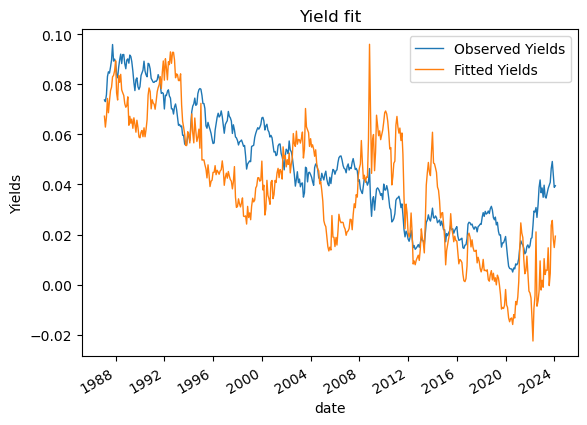

In [883]:
fig, axes = plt.subplots()
axes.plot(yield_data['Yield_110m'], label="Observed Yields", linewidth=1)
#axes.plot(yield_data.index,fittedYields.iloc[:, 100], label = "Fitted Yields", linewidth=1)
axes.plot(yield_data.index,fittedYields_np[:, 110], label = "Fitted Yields", linewidth=1)
#axes.plot(yield_data.index,risk_premium[:, 110], label = "Risk Premium", linewidth=1)
fig.autofmt_xdate()
axes.set_xlabel("date")
axes.set_ylabel("Yields")
axes.set_title("Yield fit")
axes.legend()
plt.show()

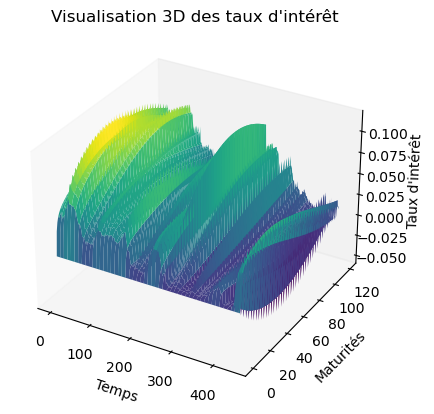

In [884]:
from mpl_toolkits.mplot3d import Axes3D

m, n = fittedYields_np.shape


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(range(n), range(m))
Z = fittedYields_np

ax.plot_surface(Y, X, Z, cmap='viridis')

# Enleve le quadrillage de fond
ax.grid(False)

#ax.set_xlim(0, m)  
#ax.set_ylim(0, n)  
#ax.set_zlim(Z.min(), Z.max()) 

# Ajoutez des étiquettes d'axes et un titre
ax.set_xlabel('Temps')
ax.set_ylabel('Maturités')
ax.set_zlabel('Taux d\'intérêt')
ax.set_title('Visualisation 3D des taux d\'intérêt')

# Affichez le graphique 3D
plt.show()

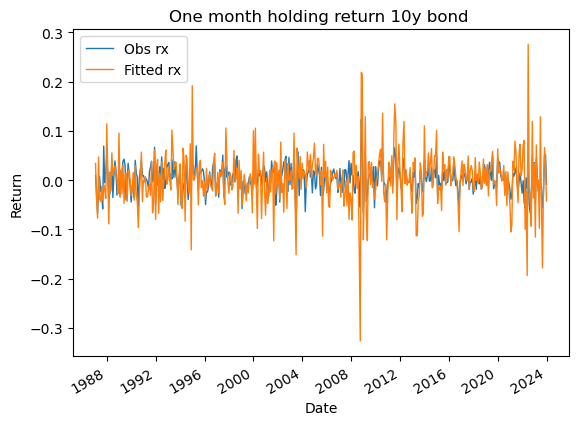

In [885]:
fig, axes = plt.subplots()
axes.plot(yield_data.iloc[:-1,].index,rx.T[:, 118], label = "Obs rx", linewidth=1)
axes.plot(yield_data.iloc[:-1,].index,rx_model[:, 118], label = "Fitted rx", linewidth=1)
fig.autofmt_xdate()
axes.set_xlabel("Date")
axes.set_ylabel("Return")
axes.set_title("One month holding return 10y bond ")
axes.legend()
#plt.savefig('C:/Users/bossd/OneDrive/Dauphine/M2/Ielpo/Term-Structure-Modeling-Based-On-Adrian-Crump-and-Moench-2013--main/holding_return_10y')
plt.show()

In [886]:
yield_data

,Yield_1m,Yield_2m,Yield_3m,Yield_4m,Yield_5m,Yield_6m,Yield_7m,Yield_8m,Yield_9m,Yield_10m,...,Yield_111m,Yield_112m,Yield_113m,Yield_114m,Yield_115m,Yield_116m,Yield_117m,Yield_118m,Yield_119m,Yield_120m
Date,,,,,,,,,,,,,,,,,,,,,
1987-01-30,0.056923,0.057213,0.057496,0.057772,0.058040,0.058303,0.058559,0.058809,0.059054,0.059294,...,0.073839,0.073927,0.074013,0.074099,0.074184,0.074268,0.074351,0.074433,0.074515,0.074596
1987-02-27,0.056587,0.057009,0.057410,0.057792,0.058156,0.058504,0.058835,0.059152,0.059456,0.059747,...,0.073170,0.073252,0.073333,0.073414,0.073493,0.073572,0.073650,0.073728,0.073805,0.073881
1987-03-31,0.058929,0.059335,0.059723,0.060094,0.060450,0.060790,0.061117,0.061431,0.061733,0.062023,...,0.075943,0.076023,0.076102,0.076180,0.076257,0.076334,0.076409,0.076484,0.076559,0.076632
1987-04-30,0.055653,0.057766,0.059636,0.061289,0.062752,0.064046,0.065191,0.066205,0.067104,0.067901,...,0.083142,0.083199,0.083254,0.083309,0.083363,0.083417,0.083469,0.083521,0.083571,0.083621
1987-05-29,0.060237,0.061824,0.063270,0.064589,0.065793,0.066890,0.067892,0.068807,0.069643,0.070406,...,0.085049,0.085104,0.085157,0.085210,0.085262,0.085313,0.085364,0.085414,0.085463,0.085512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,0.051160,0.052297,0.053146,0.053756,0.054169,0.054419,0.054535,0.054542,0.054463,0.054313,...,0.046347,0.046371,0.046396,0.046421,0.046446,0.046470,0.046495,0.046520,0.046545,0.046570
2023-10-31,0.058042,0.057500,0.056982,0.056486,0.056013,0.055560,0.055128,0.054715,0.054321,0.053945,...,0.049221,0.049259,0.049297,0.049334,0.049372,0.049410,0.049447,0.049484,0.049522,0.049559
2023-11-30,0.057052,0.056361,0.055699,0.055063,0.054454,0.053871,0.053311,0.052775,0.052262,0.051770,...,0.044012,0.044051,0.044090,0.044129,0.044169,0.044208,0.044247,0.044286,0.044326,0.044365


In [887]:
column_means = yield_data.mean()
column_means.shape

(120,)

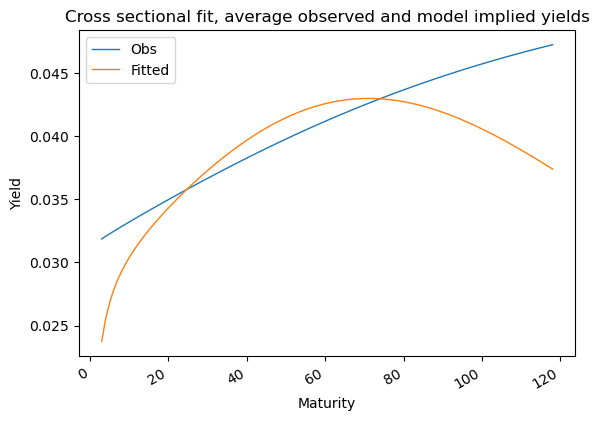

In [888]:
fig, axes = plt.subplots()
axes.plot(fittedYields[3:119].index,yield_data.mean()[3:119], label = "Obs", linewidth=1)
axes.plot(fittedYields[3:119].index,fittedYields.mean()[3:119], label = "Fitted", linewidth=1)
fig.autofmt_xdate()
axes.set_xlabel("Maturity")
axes.set_ylabel("Yield")
axes.set_title("Cross sectional fit, average observed and model implied yields")
axes.legend()
#plt.savefig('C:/Users/bossd/OneDrive/Dauphine/M2/Ielpo/Term-Structure-Modeling-Based-On-Adrian-Crump-and-Moench-2013--main/cross-sectional_fit')
plt.show()

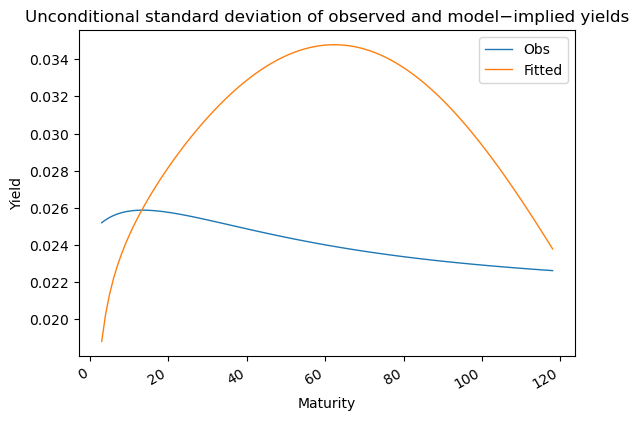

In [889]:
fig, axes = plt.subplots()
axes.plot(fittedYields[3:119].index,yield_data.std()[3:119], label = "Obs", linewidth=1)
axes.plot(fittedYields[3:119].index,fittedYields.std()[3:119], label = "Fitted", linewidth=1)
fig.autofmt_xdate()
axes.set_xlabel("Maturity")
axes.set_ylabel("Yield")
axes.set_title("Unconditional standard deviation of observed and model−implied yields")
axes.legend()
#plt.savefig('C:/Users/bossd/OneDrive/Dauphine/M2/Ielpo/Term-Structure-Modeling-Based-On-Adrian-Crump-and-Moench-2013--main/std_model')
plt.show()

In [890]:
pca_factors_2_df_graph= pca_factors_2_df.iloc[:5,:].T
pca_factors_2_df_graph.columns = pca_factors_df.columns
pca_factors_2_df_graph.iloc[:,:]

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,1.135857,1.131472,1.242320,1.548904,1.654312
1,0.310703,0.210274,0.278429,0.537347,0.451450
2,-0.664952,-0.419672,-0.491751,0.791147,0.839944
3,-0.048086,0.154725,0.019976,1.954090,1.267896
4,-0.262195,-0.517809,-0.343719,0.706925,-0.521474
...,...,...,...,...,...
115,0.080572,-0.373609,-0.262282,-1.569661,3.254543
116,0.093966,-0.362400,-0.178746,-3.112432,3.481512
117,0.064507,0.051998,-0.092297,3.375894,-0.130151
118,-0.001378,-0.113276,-0.070278,-0.333776,1.297248


In [891]:
pca_factors_df

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,0.809043,0.397802,0.014202,0.004597,0.000211
1,0.778311,0.336096,0.011116,0.001852,0.000108
2,0.750581,0.289976,0.008143,0.000299,-0.000019
3,0.724031,0.251893,0.005564,-0.000618,-0.000110
4,0.698044,0.218602,0.003408,-0.001160,-0.000160
...,...,...,...,...,...
115,-0.316523,0.209873,-0.004277,0.000900,-0.000089
116,-0.317956,0.215712,-0.004517,0.000981,-0.000101
117,-0.319342,0.221513,-0.004757,0.001064,-0.000113
118,-0.320684,0.227277,-0.004999,0.001147,-0.000125


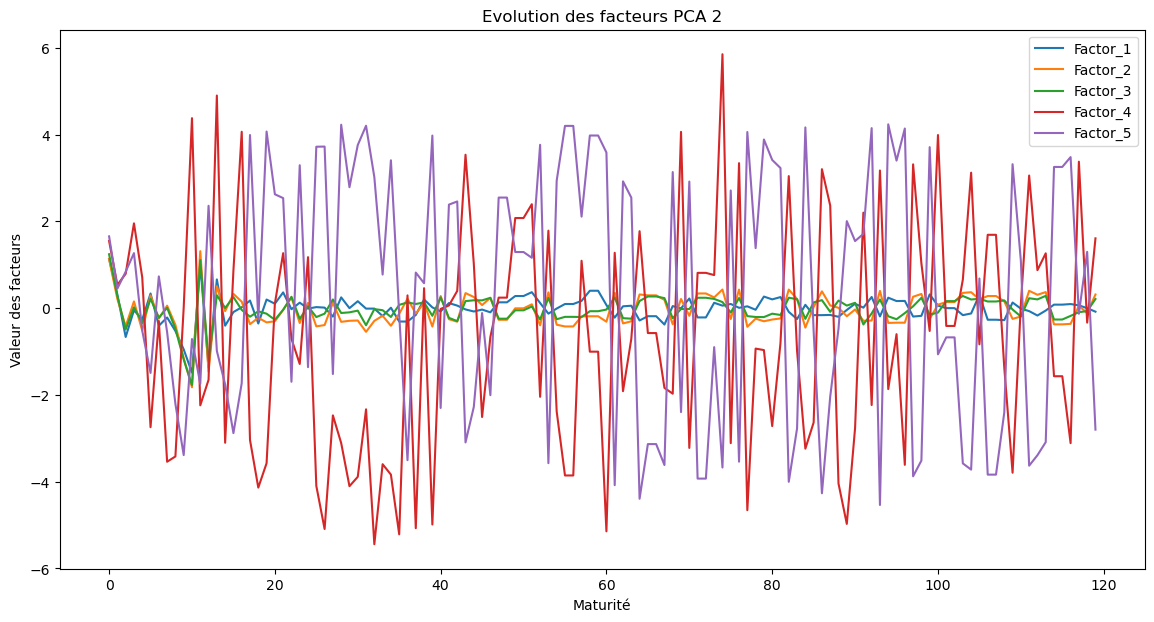

In [892]:
plt.figure(figsize=(14,7)) 

for column in pca_factors_2_df_graph.columns:
    plt.plot(pca_factors_2_df_graph.index, pca_factors_2_df_graph[column], label=column)


plt.title('Evolution des facteurs PCA 2')
plt.xlabel('Maturité')
plt.ylabel('Valeur des facteurs')
plt.legend()
#plt.savefig('C:/Users/bossd/OneDrive/Dauphine/M2/Ielpo/Term-Structure-Modeling-Based-On-Adrian-Crump-and-Moench-2013--main/PCA_2')
plt.show()
